### Trying only tokenization and stop-words as a preprocess 

In [1]:
import pandas as pd 
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import unidecode
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import re

In [2]:
#loading the data
# Load data from a text file
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, sentence = line.strip().split('\t', 1)  # Split on the first tab character
            data.append([sentence, int(label)])
    return pd.DataFrame(data, columns=['sentence', 'label'])

# file_path
file_path = 'TRAINING_DATA.txt'

#assign the data into pandas DF
data = load_data(file_path)

data.head()

,sentence,label
0,"Cuando conocí a Janice en 2013 , una familia n...",1
1,Hwang habló en Sur de este año por Southwest M...,0
2,Usted podría pensar Katy Perry y Robert Pattin...,1
3,Cualquiera que haya volado los cielos del crea...,1
4,"Bueno , este cantante tendrá un LARGO tiempo p...",1


In [3]:
#tokenizated and stop words but not removing any special characters 
def preprocess_text_ts(text):
    words = word_tokenize(text)
    # Remove stop words from the tokenized words
    #words = [word for word in words if word not in stop_words]
    # Join the words back into a single string with spaces-
    return ' '.join(words)

data['cleaned_sentences'] = data['sentence'].apply(preprocess_text_ts)

In [4]:
data.head()

,sentence,label,cleaned_sentences
0,"Cuando conocí a Janice en 2013 , una familia n...",1,"Cuando conocí a Janice en 2013 , una familia n..."
1,Hwang habló en Sur de este año por Southwest M...,0,Hwang habló en Sur de este año por Southwest M...
2,Usted podría pensar Katy Perry y Robert Pattin...,1,Usted podría pensar Katy Perry y Robert Pattin...
3,Cualquiera que haya volado los cielos del crea...,1,Cualquiera que haya volado los cielos del crea...
4,"Bueno , este cantante tendrá un LARGO tiempo p...",1,"Bueno , este cantante tendrá un LARGO tiempo p..."


In [5]:
#unprocessed data 
def count_vectorize(data, text_column):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data[text_column])
    return X, vectorizer

#gradient boost
def gradient_boosting_classification_count(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the classifier
    classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report, classifier

# Main function to tie everything together
def main_gradient_boosting_count(data, text_column):
    # Count Vectorization
    X, vectorizer = count_vectorize(data, text_column)
    y = data['label']
    
    # Classification
    accuracy, report, classifier = gradient_boosting_classification_count(X, y)
    
    # Output results
    print(f'Accuracy: {accuracy}')
    print(report)
    
    return vectorizer, classifier 

# Call the main function with gradient boosting
vectorizer, classifier = main_gradient_boosting_count(data, 'cleaned_sentences')

Accuracy: 0.5234899328859061
              precision    recall  f1-score   support

           0       0.51      0.80      0.62      1751
           1       0.57      0.26      0.36      1825

    accuracy                           0.52      3576
   macro avg       0.54      0.53      0.49      3576
weighted avg       0.54      0.52      0.49      3576



### embeding 

## Libraries to install

In [6]:
!pip install transformers --user


In [7]:
!pip install torch --user


In [8]:
import transformers
import torch


In [9]:
from transformers import AutoTokenizer, AutoModel
import torch

### loading the data

In [10]:
#loading the data
# Load data from a text file
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, sentence = line.strip().split('\t', 1)  # Split on the first tab character
            data.append([sentence, int(label)])
    return pd.DataFrame(data, columns=['sentence', 'label'])

# file_path
file_path = 'TRAINING_DATA.txt'

#assign the data into pandas DF
data_2 = load_data(file_path)

data_2.head()

,sentence,label
0,"Cuando conocí a Janice en 2013 , una familia n...",1
1,Hwang habló en Sur de este año por Southwest M...,0
2,Usted podría pensar Katy Perry y Robert Pattin...,1
3,Cualquiera que haya volado los cielos del crea...,1
4,"Bueno , este cantante tendrá un LARGO tiempo p...",1


### using embedding with a transformer model specialize in 'european spanish' and applying gradient boost to classify

In [12]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Load pre-trained Spanish BETO model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = AutoModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embedding for the [CLS] token
    embedding = outputs.last_hidden_state[0][0].numpy()
    return embedding

# Apply embedding to the 'sentences' column
data_2['embedding'] = data_2['sentence'].apply(embed_text)

# Split the data
X = np.array(data_2['embedding'].tolist())
y = data_2['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
gbc = GradientBoostingClassifier()

# Train the classifier
gbc.fit(X_train, y_train)

# Predict on the test set
y_pred = gbc.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.6484899328859061


In [14]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      1751
           1       0.64      0.71      0.67      1825

    accuracy                           0.65      3576
   macro avg       0.65      0.65      0.65      3576
weighted avg       0.65      0.65      0.65      3576



In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

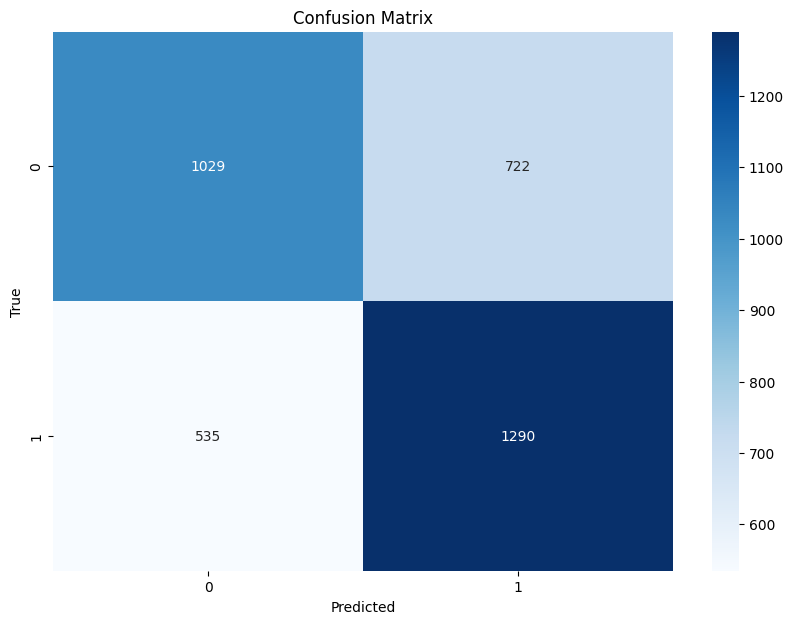

In [16]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()